In [1]:
import numpy as np
np.set_printoptions(precision=3) # only 3 decimals in print
import torch
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')
from tqdm import tqdm

plt.rc("axes", labelsize = 11)
plt.rc("xtick", labelsize = 10, top = True, direction="in")
plt.rc("ytick", labelsize = 10, right = True, direction="in")
plt.rc("axes", titlesize = 13)
plt.rc("legend", fontsize = 10, loc = "best")
plt.rc('animation', html='jshtml')

In [2]:
def nice_plot(ax):
    ax.set(xlabel="$x_1$", ylabel="$x_2$")
    ax.axhline(0, color="k")
    ax.axvline(0, color="k")
    ax.grid(alpha=0.5)

### 6.1 Classification: 2D case

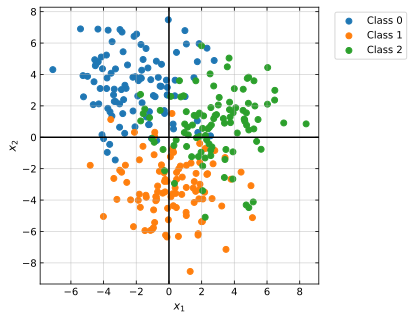

In [3]:
# a) Make a dataset, {((x_{1,i}, x_{2,i}), label_i)}, where the (x_{1,i}, x_{2,i}) points are normally distributed (with standard deviation 2)
# around (−2,3), (0.5,−3), and (3,1), respectively.
np.random.seed(0)
fig, ax = plt.subplots(figsize=(5,5))
nice_plot(ax)

sigmas = [2, 2, 2]
centers = [[-2., 3.], [0.5, -3.], [3., 1.]]

all_points = []
all_labels = []
for label, (center, sigma) in enumerate(zip(centers, sigmas)):
    points = sigma*np.random.randn(100, 2) + np.array(center)
    all_points.append(points)
    all_labels.append([label]*len(points))
    ax.scatter(*points.T, label=f"Class {label}")
ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

fig.savefig('ex56_fig1.png')

b) Make a one-layer feedforward linear neural network with two inputs and three outputs. Train the network using a cross-entropy loss function.

In [4]:
class Model(torch.nn.Module):
    def __init__(self, n_features=2, n_classes=3):
        super().__init__()
        self.fc1 = torch.nn.Linear(n_features, n_classes)
    
    def forward(self, x):
        x = self.fc1(x)
        return x

    def predict_label(self, x):
        x = self.forward(x)
        return torch.argmax(x, dim=1)

In [5]:
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

# Prepare the data
Ps = torch.tensor(np.vstack(all_points), dtype=torch.float32)  # Shape: (300, 2)
labels = torch.tensor(np.hstack(all_labels), dtype=torch.long)  # Shape: (300,)

# Define a custom dataset
class PointsDataset(Dataset):
    def __init__(self, points, labels):
        self.points = points
        self.labels = labels

    def __len__(self):
        return len(self.points)

    def __getitem__(self, idx):
        return self.points[idx], self.labels[idx]

# Create DataLoader
dataset = PointsDataset(Ps, labels)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Instantiate the model, loss function, and optimizer
model = Model(n_features=2, n_classes=3)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
epochs = 100
for epoch in tqdm(range(epochs), desc='Training'):
    total_loss = 0
    for batch_points, batch_labels in dataloader:
        optimizer.zero_grad()  # Zero the gradients

        # Forward pass
        outputs = model(batch_points)  # Shape: (batch_size, 3)
        
        # Compute loss
        loss = loss_fn(outputs, batch_labels)  # CrossEntropyLoss expects raw logits and labels
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        total_loss += loss.item()

    # Print average loss per epoch
    avg_loss = total_loss / len(dataloader)

Training: 100%|██████████| 100/100 [00:00<00:00, 154.29it/s]


c) Introduce that the network can predict the class for an input $(x_1, x_2)$ as the label of maximum probability. Plot the labels that are predicted for the points in the dataset

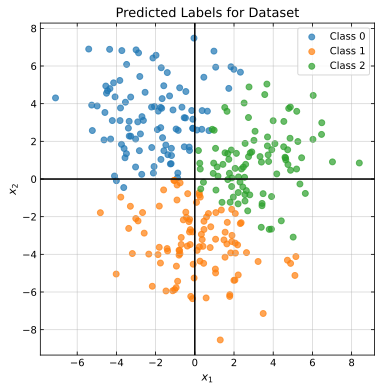

In [6]:
fig, ax = plt.subplots(figsize=(6, 6))
nice_plot(ax)

# Predict labels for the entire dataset
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient computation
    predicted_labels = model.predict_label(Ps)  # Predict labels for all points

# Scatter plot: color points by predicted label
for label in range(3):  # Assuming three classes: 0, 1, 2
    mask = predicted_labels == label  # Select points for the current label
    ax.scatter(*Ps[mask].T, c=f'C{label}', label=f"Class {label}", alpha=0.7)

# Add legend and labels
ax.set_title("Predicted Labels for Dataset")
ax.legend()

fig.savefig('ex56_fig2.png')

Make a regular grid of $(x_1, x_2)$ values. Query the neural network for the corresponding labels. Plot them

c:\Users\Jakob\anaconda3\envs\COMPHY\Lib\site-packages\torch\functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


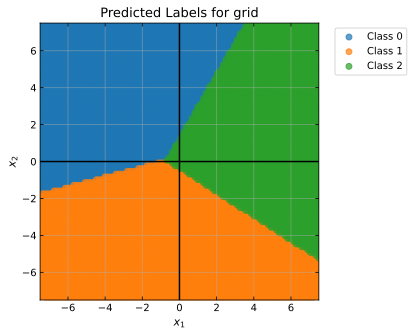

In [7]:
x1s = torch.linspace(-7.5, 7.5, 100)
x2s = torch.linspace(-7.5, 7.5, 100)
X1s, X2s = torch.meshgrid(x1s, x2s)
Xs = torch.stack([X1s.flatten(), X2s.flatten()], dim=1)

fig, ax = plt.subplots(figsize=(5, 5))
nice_plot(ax)

# Predict labels for the entire dataset
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient computation
    predicted_labels = model.predict_label(Xs)  # Predict

# Scatter plot: color points by predicted label
for label in range(3):  # Assuming three classes: 0, 1, 2
    mask = predicted_labels == label  # Select points for the current label
    ax.scatter(*Xs[mask].T, c=f'C{label}', label=f"Class {label}", alpha=0.7)

# Add legend and labels
ax.set(xlim=[-7.5,7.5], ylim=[-7.5,7.5], title="Predicted Labels for grid")
ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

fig.savefig('ex56_fig3.png')

### 6.2 Non-trivial 2D classification

In [8]:
def f(x1, x2):
    term1 = (x1**2 + x2 - 11)**2
    term2 = (x1 + x2**2 - 7)**2
    return term1 + term2

def get_label(f):
    if f <= 25:
        return 0
    elif 25 < f <= 300:
        return 1
    else:
        return 2

Make a 2D dataset and plot it

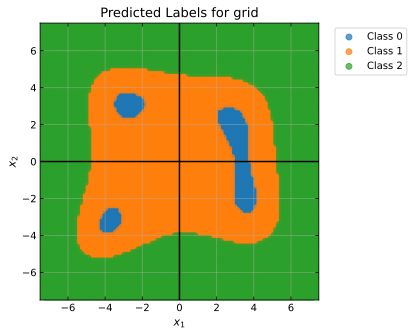

In [9]:
labels = torch.tensor([get_label(f(x1, x2)) for x1, x2 in Xs], dtype=torch.long)
fig, ax = plt.subplots(figsize=(5, 5))
nice_plot(ax)

for label in range(3):  # Assuming three classes: 0, 1, 2
    mask = labels == label  # Select points for the current label
    ax.scatter(*Xs[mask].T, c=f'C{label}', label=f"Class {label}", alpha=0.7)

# Add legend and labels
ax.set(xlim=[-7.5,7.5], ylim=[-7.5,7.5], title="Predicted Labels for grid")
ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

fig.savefig('ex56_fig4.png')

Split the data randomly in 80% training, 10% validation, and 10% test partitions.

f) Setup three different neural network models all accepting two inputs (the $x_1$ and $x_2$) and providing three outputs (the weights for the three labels)

In [10]:
# Set random seed for reproducibility
torch.manual_seed(0)

# Total number of data points
n = Xs.size(0)

# Shuffle indices
indices = torch.randperm(n)

# Define split sizes
n_train = int(0.8 * n)
n_val = int(0.1 * n)
n_test = n - n_train - n_val

# Split indices
train_indices = indices[:n_train]
val_indices = indices[n_train:n_train + n_val]
test_indices = indices[n_train + n_val:]

# Split data
Xs_train, Xs_val, Xs_test = Xs[train_indices], Xs[val_indices], Xs[test_indices]
labels_train, labels_val, labels_test = labels[train_indices], labels[val_indices], labels[test_indices]

# Wrap data in Custom dataset
train_dataset = PointsDataset(Xs_train, labels_train)
val_dataset = PointsDataset(Xs_val, labels_val)
test_dataset = PointsDataset(Xs_test, labels_test)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print sizes to verify
print(f"Training set: {len(train_dataset)} samples")
print(f"Validation set: {len(val_dataset)} samples")
print(f"Test set: {len(test_dataset)} samples")

Training set: 8000 samples
Validation set: 1000 samples
Test set: 1000 samples


In [11]:
# I already defined the first model.
# The next network has 10 nodes in a hidden layer between the input and output layers. Apply SiLU activation to the 10 hidden nodes.
class DeeperModel(torch.nn.Module):
    def __init__(self, n_features=2, n_classes=3):
        super().__init__()
        self.fc1 = torch.nn.Linear(n_features, 10)
        self.activation = torch.nn.SiLU()
        self.fc2 = torch.nn.Linear(10, n_classes)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x

    def predict_label(self, x):
        x = self.forward(x)
        return torch.argmax(x, dim=1)

# The final network has two hidden layers of 10 nodes, each with SiLU activation.
class DeepestModel(torch.nn.Module):
    def __init__(self, n_features=2, n_classes=3):
        super().__init__()
        self.fc1 = torch.nn.Linear(n_features, 10)
        self.activation = torch.nn.SiLU()
        self.fc2 = torch.nn.Linear(10, 10)
        self.fc3 = torch.nn.Linear(10, n_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = self.activation(x)
        x = self.fc3(x)
        return x

    def predict_label(self, x):
        x = self.forward(x)
        return torch.argmax(x, dim=1)

g) Fit the networks and test them.

In [12]:
def train_model(model, train_dataloader, val_dataloader, loss_fn, optimizer, n_epochs):
    train_losses = []
    val_losses = []

    for epoch in tqdm(range(n_epochs), desc=f'Training {model.__class__.__name__}'):
        model.train()  # Set the model to training mode
        total_loss = 0

        for batch_points, batch_labels in train_dataloader:
            optimizer.zero_grad()  # Zero the gradients

            # Forward pass
            outputs = model(batch_points)

            # Compute loss
            loss = loss_fn(outputs, batch_labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Compute average training loss
        avg_train_loss = total_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)

        # Validation loss
        model.eval()
        total_loss = 0

        with torch.no_grad():
            for batch_points, batch_labels in val_dataloader:
                outputs = model(batch_points)
                loss = loss_fn(outputs, batch_labels)
                total_loss += loss.item()

        avg_val_loss = total_loss / len(val_dataloader)
        val_losses.append(avg_val_loss)

    return train_losses, val_losses, model

In [13]:
# Instantiate the models
model = Model(n_features=2, n_classes=3)
deeper_model = DeeperModel(n_features=2, n_classes=3)
deepest_model = DeepestModel(n_features=2, n_classes=3)

# Instantiate the loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
optimizer_deeper = optim.Adam(deeper_model.parameters(), lr=0.01)
optimizer_deepest = optim.Adam(deepest_model.parameters(), lr=0.01)

# Train the models
n_epochs = 100
train_losses, val_losses, model = train_model(model, train_dataloader, val_dataloader, loss_fn, optimizer, n_epochs)
train_losses_deeper, val_losses_deeper, deeper_model = train_model(deeper_model, train_dataloader, val_dataloader, loss_fn, optimizer_deeper, n_epochs)
train_losses_deepest, val_losses_deepest, deepest_model = train_model(deepest_model, train_dataloader, val_dataloader, loss_fn, optimizer_deepest, n_epochs)

# Collect the losses and trained models in lists
train_losses_list = [train_losses, train_losses_deeper, train_losses_deepest]
val_losses_list = [val_losses, val_losses_deeper, val_losses_deepest]
model_list = [model, deeper_model, deepest_model]

# Plot the training and validation losses
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

for ax, train_losses, val_losses in zip(axes[:,0], train_losses_list, val_losses_list):
    ax.set(xlabel='Epoch', ylabel='Loss')
    ax.plot(range(1, n_epochs + 1), train_losses, label='Training loss')
    ax.plot(range(1, n_epochs + 1), val_losses, label='Validation loss')
    ax.set(ylim=[0, 3])
    ax.legend()

# Plot the decision boundaries
for ax, model in zip(axes[:,1], model_list):
    nice_plot(ax)
    ax.set_title(model.__class__.__name__)
    ax.set(xlim=[-7.5,7.5], ylim=[-7.5,7.5])

    # Predict labels for the entire dataset
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient computation
        predicted_labels = model.predict_label(Xs)  # Predict

    # Scatter plot: color points by predicted label
    for label in range(3):  # Assuming three classes: 0, 1, 2
        mask = predicted_labels == label  # Select points for the current label
        ax.scatter(*Xs[mask].T, c=f'C{label}', label=f"Class {label}", alpha=0.7)

fig.savefig('ex56_fig5.png')
    

Training DeepestModel: 100%|██████████| 100/100 [00:34<00:00,  2.90it/s]
